# 1-D Implementation

In [208]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats

to_32bit = lambda x: np.array(x, dtype=np.float32)

class GPY_Torch_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, input_dim=2):
        super(GPY_Torch_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(input_size= input_dim)
        #self.mean_module = gpytorch.means.ConstantMean()
        self.base_kernel = gpytorch.kernels.MaternKernel(ard_num_dims= input_dim, nu=2.5)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class Base_GP_Model:
    def __init__(self, quoteDateData, y_label = 'IV', type = 'surface', train_fraction = 0.6, c = 0.05, **kwargs):
        # Get the keyword arguments
        for key, value in kwargs.items():
            setattr(self, key, value)

        # If lr is not provided, set it to 0.1
        if 'lr' not in kwargs:
            self.lr = 0.1
        if 'training_iterations' not in kwargs:
            self.training_iterations = 200

        
        # Get the min and max values for normalization
        m_min, m_max = quoteDateData['m'].min(), quoteDateData['m'].max()
        T_min, T_max = quoteDateData['T'].min(), quoteDateData['T'].max()

        normalize_m = lambda x: (x - m_min) / (m_max - m_min)
        normalize_T = lambda x: (x - T_min) / (T_max - T_min)
        self.inv_normalize_m = lambda x: (x * (m_max - m_min)) + m_min
        self.inv_normalize_T = lambda x: (x * (T_max - T_min)) + T_min

        # Set the training data
        self.data = quoteDateData
        self.y_label = y_label

        partialQuoteDateData = quoteDateData.sample(frac=train_fraction, replace=False).sort_values(by=['m', 'T'])
        y_train = to_32bit((partialQuoteDateData['adj_mid_' + y_label].values))


        Z_value = stats.norm.ppf(1 - c / 2)
        noise_train = ((partialQuoteDateData['adj_ask_' + y_label]) - (partialQuoteDateData['adj_bid_' + y_label])).values**2 / (Z_value**2)
        noise_train = to_32bit((noise_train))

        self.y_train = torch.tensor(y_train, dtype=torch.float)
        self.noise = torch.tensor(noise_train, dtype=torch.float)

        if type == 'surface':
            m_train = to_32bit(normalize_m(partialQuoteDateData['m'].values))
            T_train = to_32bit(normalize_T(partialQuoteDateData['T'].values))

            self.x_train = torch.tensor(np.column_stack((m_train, T_train)), dtype=torch.float)
            self.input_dim = 2
        
        elif type == 'smile':
            m_train = to_32bit(normalize_m(partialQuoteDateData['m'].values))
            self.x_train = torch.tensor(m_train, dtype=torch.float)
            self.input_dim = 1
        else:
            raise ValueError("Invalid type. Choose 'surface' or 'smile'.")
		
		
        self.likelihood = None
        self.model = None

    def learn(self, **kwargs):
        if 'noise' in kwargs:
            self.noise = torch.tensor(kwargs['noise'], dtype=torch.float)
        if 'lr' in kwargs:
            self.lr = kwargs['lr']
        if 'training_iterations' in kwargs:
            self.training_iterations = kwargs['training_iterations']


        with gpytorch.settings.min_fixed_noise(float_value = 1e-15):

            # Initialize likelihood
            if self.likelihood is None:
                likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=self.noise, learn_additional_noise=True)
                self.likelihood = likelihood
            else:
                # Use the existing likelihood
                likelihood = self.likelihood


            if self.model is None:
                model = GPY_Torch_Model(self.x_train, self.y_train, likelihood, input_dim= self.input_dim)
                self.model = model
            else:
                # Use the existing model
                model = self.model


            # Set the model and likelihood to training mode
            model.train()
            likelihood.train()

            # Use the Adam optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)

            # "Loss" for GPs - the marginal log likelihood
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

            # Training loop
            training_iterations = self.training_iterations
            losses = []

            for i in range(training_iterations):
                optimizer.zero_grad()
                output = model(self.x_train)  # Use self.train_x instead of train_x
                loss = -mll(output, self.y_train)  # Use self.train_y instead of train_y
                losses.append(loss.item())
                loss.backward()
                optimizer.step()
                
                if (i + 1) % int(self.training_iterations/4) == 0:
                    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item():.4f}')
                    print(f'  lengthscale: {model.covar_module.base_kernel.lengthscale}')
                    print(f'  outputscale: {model.covar_module.outputscale.item():.4f}')


            self.model = model
            self.loss = losses

            # Plot training curve
            plt.figure(figsize=(10, 4))
            plt.plot(losses)
            plt.title("Negative Log Likelihood During Training")
            plt.xlabel("Iterations")
            plt.ylabel("NLL")
            plt.show()


            # Create a dictionary to store the kernel parameters
            kernel_params = {
                'lengthscale': model.covar_module.base_kernel.lengthscale.item(),
                'outputscale': model.covar_module.outputscale.item()
            }
            self.kernel_params = kernel_params

            return self

    def predict(self, x_test):
        # Convert test data to tensor
        x_test = torch.tensor(x_test, dtype=torch.float)

        # Set the model and likelihood to evaluation mode
        self.model.eval()
        self.likelihood.eval()

        # Make predictions
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = self.likelihood(self.model(x_test),
                                            noise=torch.zeros_like(x_test))
        if self.input_dim == 2:
            # Unnormalize the test data
            m_test = x_test[:, 0].numpy()
            T_test = x_test[:, 1].numpy()
            self.m_test = self.inv_normalize_m(m_test)
            self.T_test = self.inv_normalize_T(T_test)
        elif self.input_dim == 1:
            self.x_test = self.inv_normalize_m(x_test)
        else:
            raise ValueError("Invalid input dimension. Expected 1 or 2.")


        # Create a dictionary to store the predictions
        self.pred = {
            'mean': observed_pred.mean.numpy(),
            'lower': observed_pred.mean - 1.96 * observed_pred.stddev,
            'upper': observed_pred.mean + 1.96 * observed_pred.stddev,
            'variance': observed_pred.variance.numpy()
        }

        return self
    
    def plot_smile(self, figsize=(20, 10)):

        plt.figure(figsize=figsize)
        
        # Fill for the Bid-Ask Spread
        plt.fill_between(self.data['m'], self.data['adj_ask_' + self.y_label], self.data['adj_bid_' + self.y_label], alpha=0.5, label='Bid-Ask ' + self.y_label + ' Spread')
        # Fill for the Confidence Interval
        plt.fill_between(self.x_test, self.pred['lower'], self.pred['upper'], alpha=0.5, label='95% Confidence Interval for ' + self.y_label)
        # Plot the Mid-Price
        plt.plot(self.data['m'], self.data['mid_' + self.y_label], label='Mid-Price ' + self.y_label, color='b')
        # Plot the GP Mean Prediction
        plt.plot(self.x_test, self.pred['mean'], 'r', label='GP Mean Prediction for ' + self.y_label)
        # Plot the Training Data
        plt.plot(self.inv_normalize_m(self.x_train), self.y_train, 'k*', label='Training Data', markersize=4)
        # Plot the Spot Price
        #plt.axvline(x=S_0, color='black', linestyle='--', label='Spot Price')
        # Set the labels and title
        plt.xlabel('Moneyness')
        y_lab = 'Implied Volatility' if self.y_label == 'IV' else 'Total Implied Variance'
        plt.ylabel(y_lab)
        plt.title(y_lab +' vs Moneyness for ' + self.data['expiration'].iloc[0] + ' Expiry at ' + self.data['quote_date'].iloc[0])
        # Show the legend
        plt.legend()
        # Show the plot
        plt.show()


In [209]:
import pandas as pd
import numpy as np

quoteDateData = pd.read_csv('quoteDateData.csv', index_col= False)
quoteDateData.sort_values(by=['m', 'T'], inplace=True)


maturities = quoteDateData['expiration'].unique()
strikes = quoteDateData['strike'].unique()

tensor([0.0126, 0.0110, 0.0115, 0.0098, 0.0084, 0.0073, 0.0068, 0.0062, 1.0923,
        0.9182, 0.0053, 0.0053, 0.0043, 0.0065, 0.0018, 0.0018, 0.0015, 0.0013,
        0.0041, 0.0023, 0.0018, 0.0045, 0.0046, 0.0047, 0.0058, 0.0069, 0.0150,
        0.0067, 0.0193])
Iter 1250/5000 - Loss: -1.4612
  lengthscale: tensor([[2.7426]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.0001
Iter 2500/5000 - Loss: -1.5013
  lengthscale: tensor([[2.7453]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.0000
Iter 3750/5000 - Loss: -1.5075
  lengthscale: tensor([[2.7455]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.0000
Iter 5000/5000 - Loss: -1.5095
  lengthscale: tensor([[2.7455]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.0000


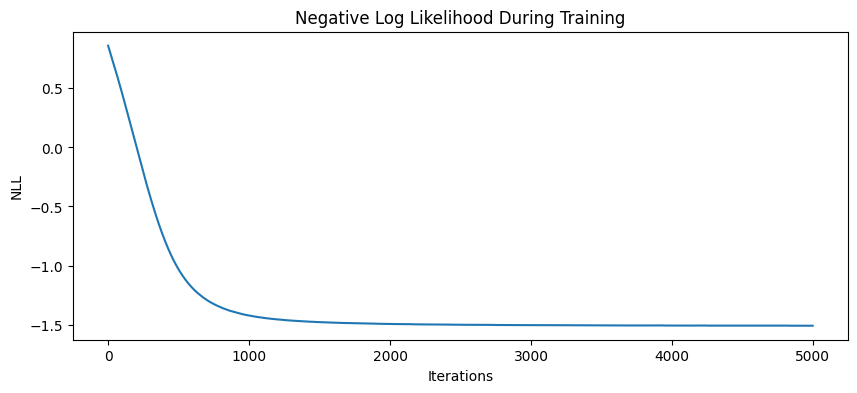

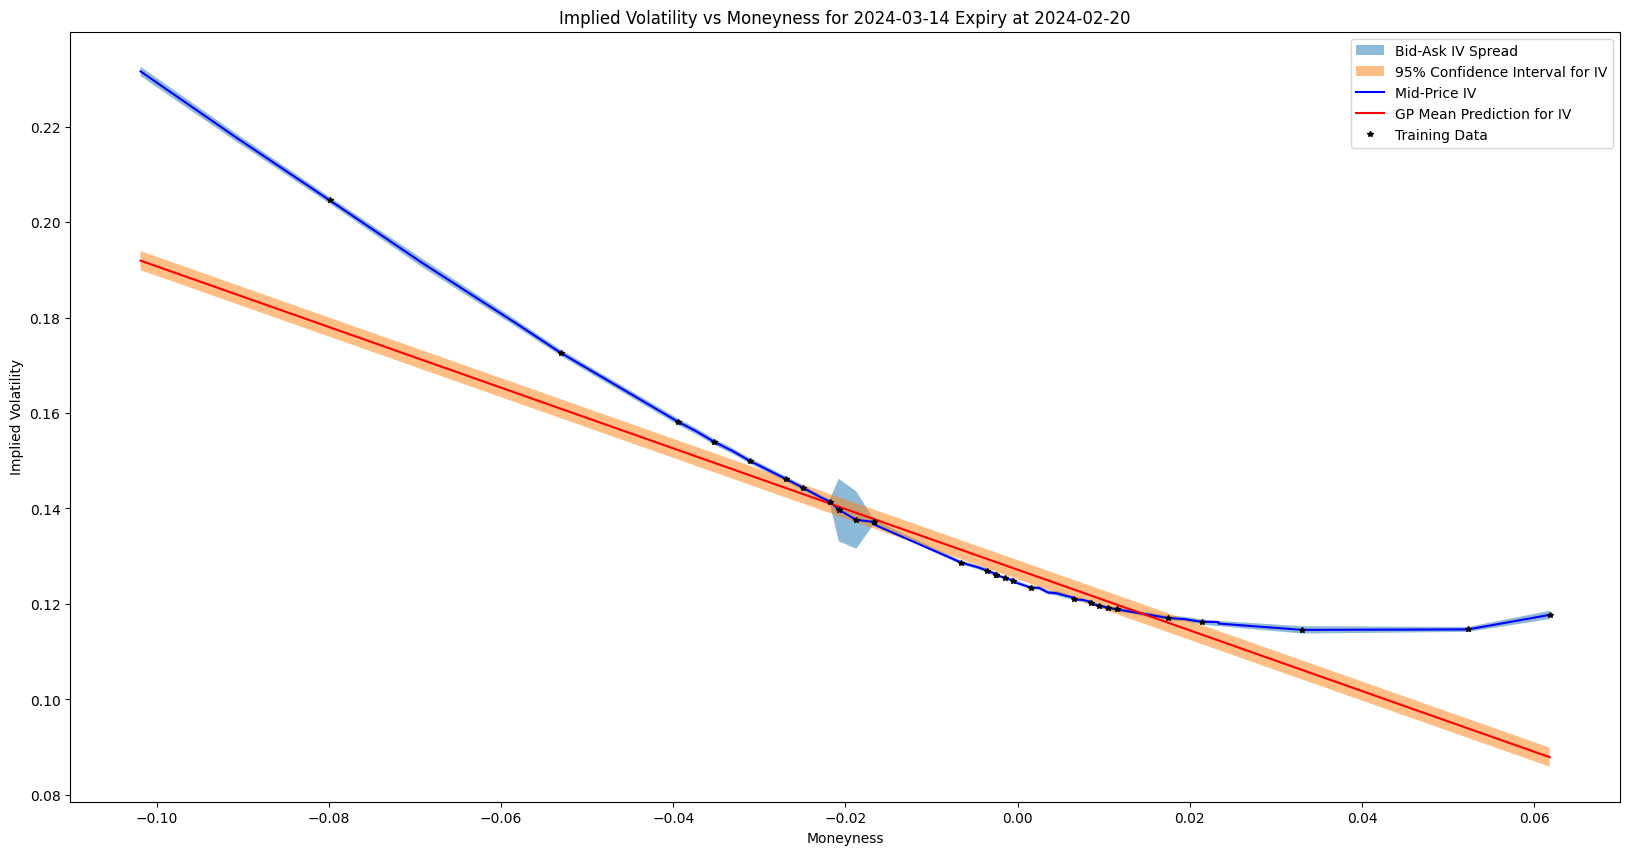

In [ ]:
maturityData = quoteDateData[quoteDateData['expiration'] == maturities[-10]]
gp_model = Base_GP_Model(maturityData, y_label = 'IV', type = 'smile', train_fraction = 0.6, lr = 0.01, training_iterations = 5000, c = 0.99)
print(gp_model.noise)
gp_model.learn()
m_test = np.linspace(0, 1, 50)
gp_model.predict(m_test).plot_smile()

ValueError: operands could not be broadcast together with shapes (50,) (154,) 

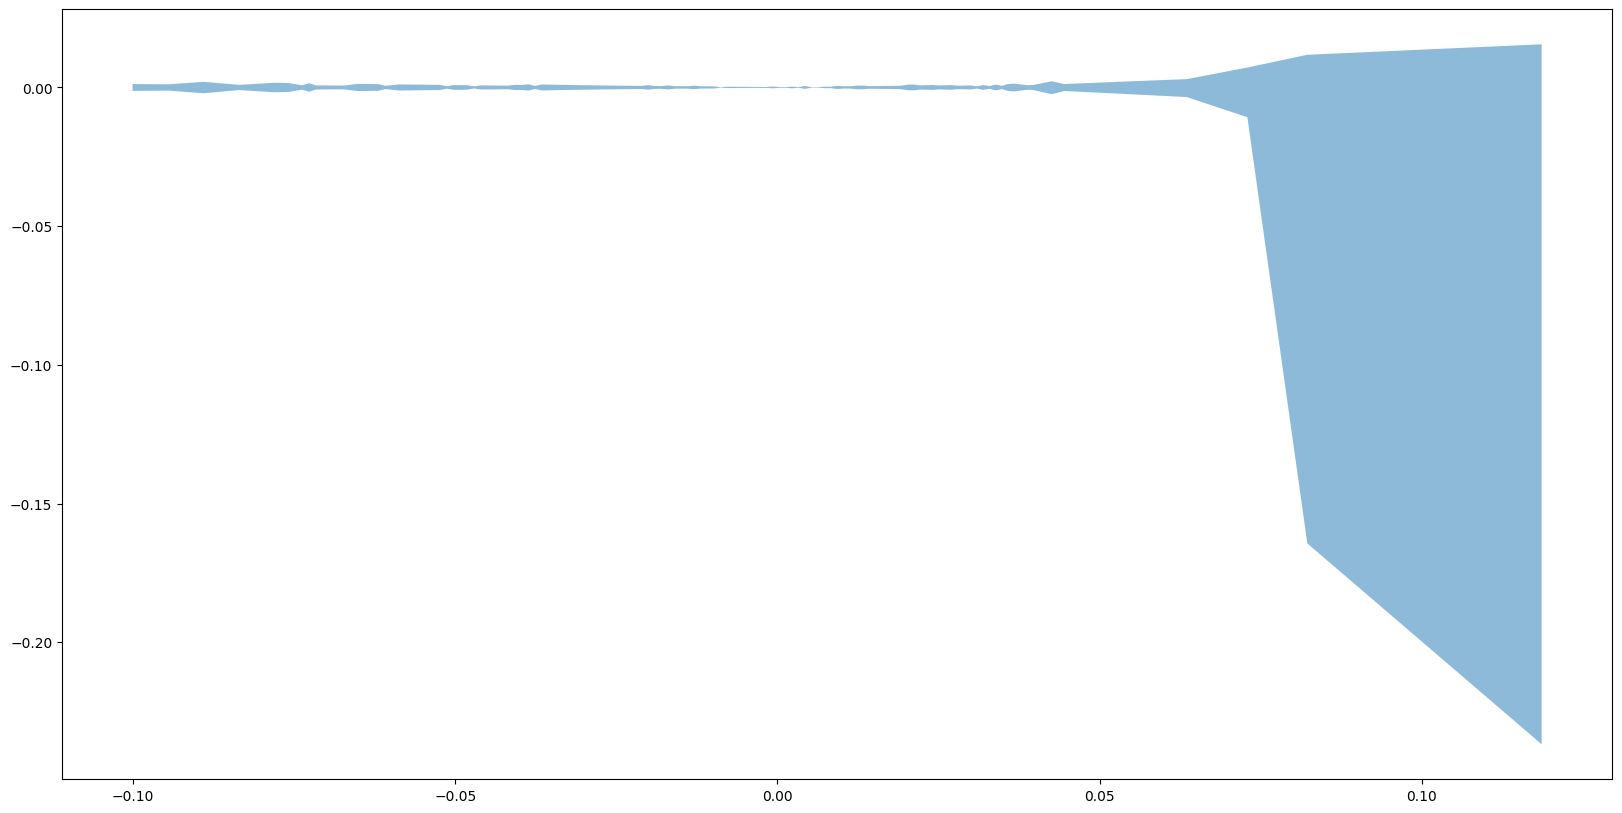

In [168]:
 def _plot_smile_centered(self, figsize=(20, 10), center_around = 'mean'):

        #

        plt.figure(figsize=figsize)
        
        # Fill for the Bid-Ask Spread
        plt.fill_between(self.data['m'], self.data['adj_ask_' + self.y_label], self.data['adj_bid_' + self.y_label], alpha=0.5, label='Bid-Ask ' + self.y_label + ' Spread')
        # Fill for the Confidence Interval
        plt.fill_between(self.x_test, self.pred['lower'], self.pred['upper'], alpha=0.5, label='95% Confidence Interval for ' + self.y_label)
        # Plot the Mid-Price
        plt.plot(self.data['m'], self.data['mid_' + self.y_label], label='Mid-Price ' + self.y_label, color='b')
        # Plot the GP Mean Prediction
        plt.plot(self.x_test, self.pred['mean'], 'r', label='GP Mean Prediction for ' + self.y_label)
        # Plot the Training Data
        plt.plot(self.inv_normalize_m(self.x_train), self.y_train, 'k*', label='Training Data', markersize=4)
        # Plot the Spot Price
        #plt.axvline(x=S_0, color='black', linestyle='--', label='Spot Price')
        # Set the labels and title
        plt.xlabel('Moneyness')
        y_lab = 'Implied Volatility' if self.y_label == 'IV' else 'Total Implied Variance'
        plt.ylabel(y_lab)
        plt.title(y_lab +' vs Moneyness for ' + self.data['expiration'].iloc[0] + ' Expiry at ' + self.data['quote_date'].iloc[0])
        # Show the legend
        plt.legend()
        # Show the plot
        plt.show()

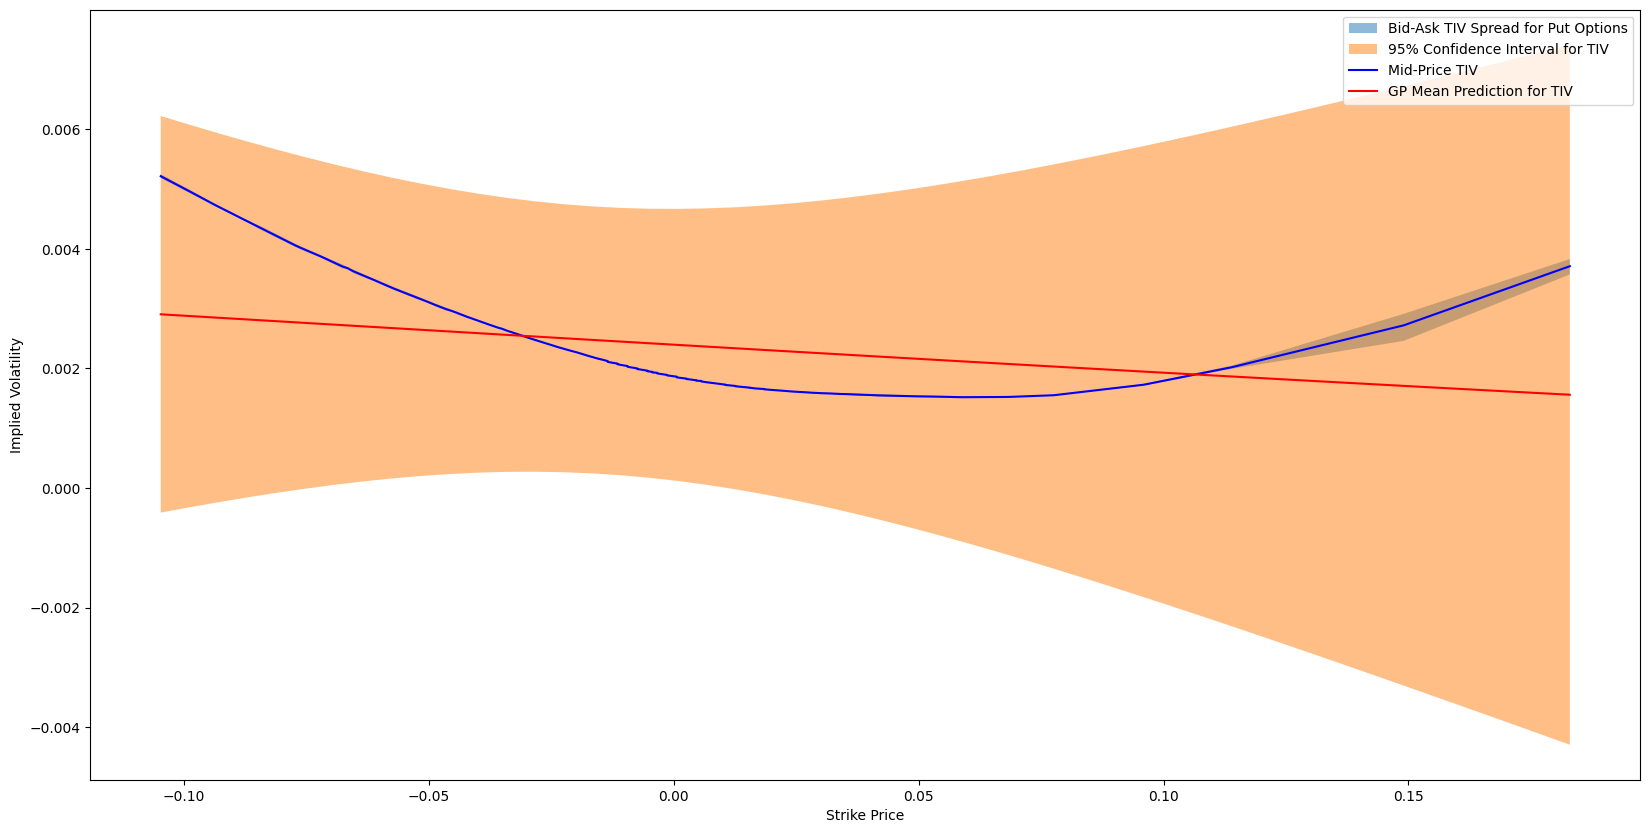

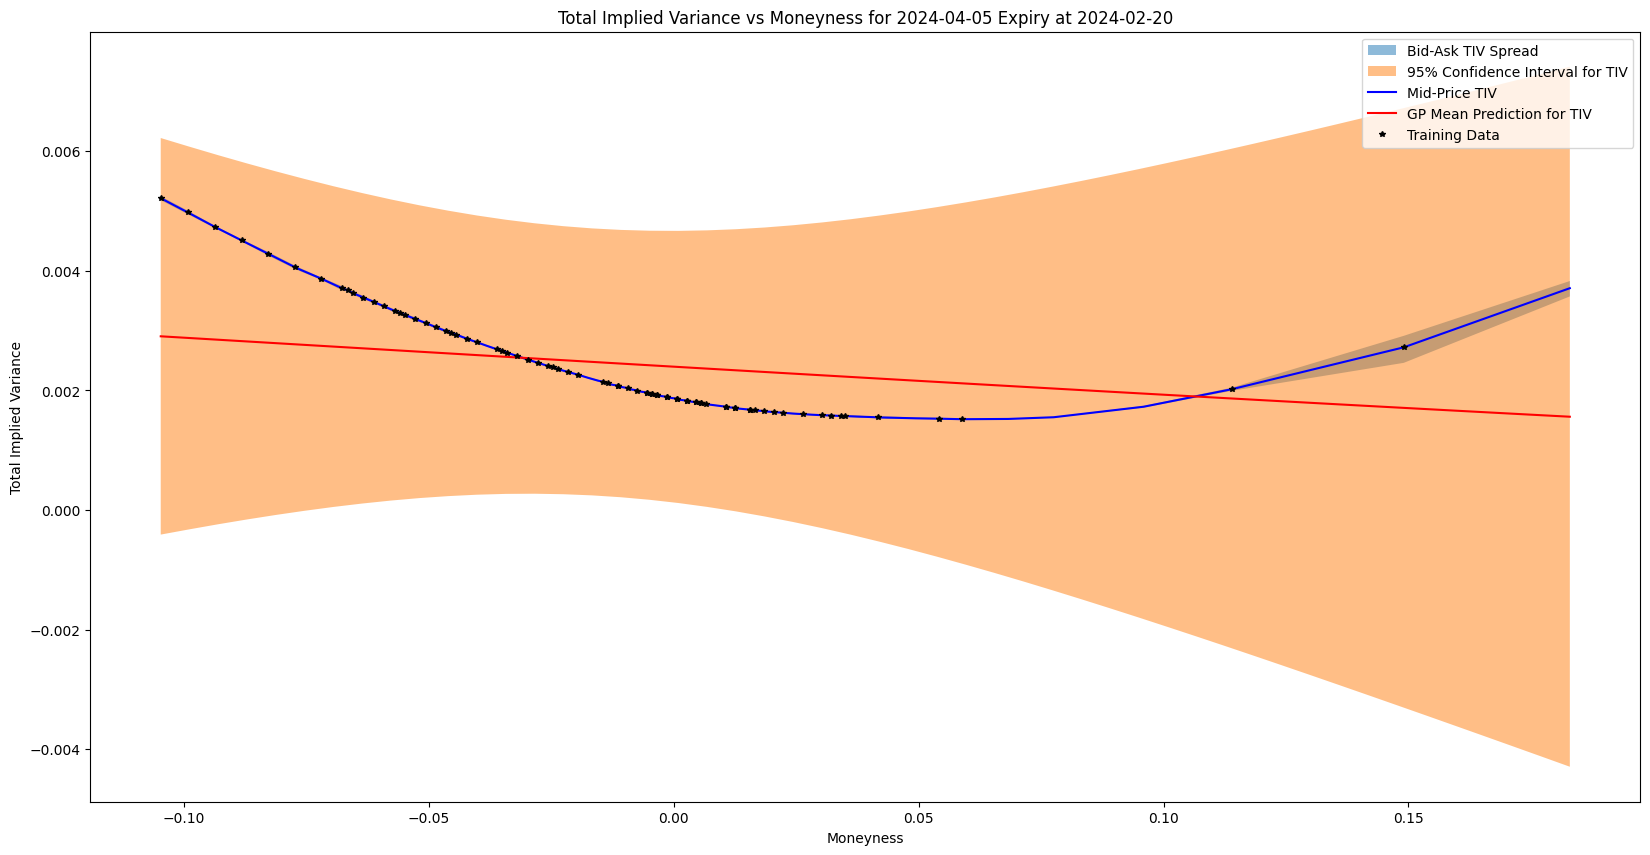

In [148]:
self = gp_model




pltData = self.data.copy()
pltData.sort_values(by=['m', 'T'], inplace=True)

plt.figure(figsize=(20, 10))

plt.fill_between(pltData['m'], pltData['adj_ask_'+ self.y_label], pltData['adj_bid_'+ self.y_label] , alpha=0.5, label='Bid-Ask ' + self.y_label +' Spread for Put Options')
plt.fill_between(self.x_test, self.pred['lower'], self.pred['upper'], alpha=0.5, label='95% Confidence Interval for ' + self.y_label)

plt.plot(pltData['m'], pltData['mid_'+ self.y_label], label = 'Mid-Price '+ self.y_label, color='b')
plt.plot(self.x_test, self.pred['mean'], 'r', label='GP Mean Prediction for ' + self.y_label)
#plt.plot(self.x_train, self.y_train, 'k*', label='Training Data')

#plt.axvline(x=S_0, color='black', linestyle='--', label='Spot Price')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
#plt.title( 'Implied Volatility vs Strike Price for '+ putData['expiration'].iloc[0].strftime('%Y-%m-%d') + ' Expiry at ' + putData['quote_date'].iloc[0].strftime('%Y-%m-%d') )

plt.legend()
plt.show()



In [105]:
self.noise

tensor([3.8765e-07, 1.5138e-07, 1.3247e-07, 4.6406e-07, 4.0697e-07, 3.9596e-07,
        1.9891e-07, 7.1484e-07, 4.7011e-07, 4.4507e-07, 2.6964e-07, 3.9948e-07,
        3.7879e-07, 3.5875e-07, 4.8954e-07, 2.0629e-07, 4.4091e-07, 4.1869e-07,
        1.8112e-07, 2.7586e-07, 2.6250e-07, 1.5979e-07, 1.5220e-07, 1.4509e-07,
        1.4161e-07, 1.3845e-07, 1.3228e-07, 1.9785e-07, 1.8961e-07, 1.8202e-07,
        1.7846e-07, 1.0421e-07, 1.5765e-07, 2.2030e-07, 2.1719e-07, 7.5687e-08,
        9.2827e-08, 9.2827e-08, 6.6870e-08, 1.3195e-07, 1.3195e-07, 5.9680e-08,
        5.9680e-08, 8.7926e-08, 7.5536e-08, 7.5536e-08, 1.4375e-07, 1.4375e-07,
        3.6144e-08, 3.6144e-08, 1.3611e-07, 1.0771e-07, 1.0771e-07, 9.4870e-08,
        9.4870e-08, 1.2840e-07, 1.2840e-07, 1.5680e-07, 2.2050e-07, 1.3045e-07,
        1.3045e-07, 1.0899e-07, 1.8983e-07, 1.3823e-07, 1.7422e-07, 4.6901e-07,
        1.2923e-07, 5.7343e-07, 6.3840e-07, 4.6841e-07, 3.1347e-07, 1.9932e-07,
        1.0741e-07, 6.0263e-08, 2.5196e-

# 2-D Implementation

In [22]:
noise_test

array([1.60472486e-11, 9.89491044e-12, 1.60513070e-11, 1.05599597e-11,
       1.77896797e-11, 1.86522604e-11, 1.96532812e-11, 1.81551264e-11,
       2.21433052e-11, 2.73587654e-11, 4.91828316e-11, 7.85286236e-11,
       1.23834743e-10, 6.10134946e-11, 2.54640349e-11, 1.73583988e-11,
       1.14801027e-11, 9.99174484e-12, 1.53516830e-11, 1.61424734e-11,
       1.08667104e-11, 1.13182220e-11, 1.24996409e-11])

1D Implementation

C:\Users\Emre\AppData\Local\Temp\ipykernel_27340\2590873343.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_matrix = torch.tensor(noise_matrix, dtype=torch.float32)
C:\Users\Emre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gpytorch\likelihoods\noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
C:\Users\Emre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not spe

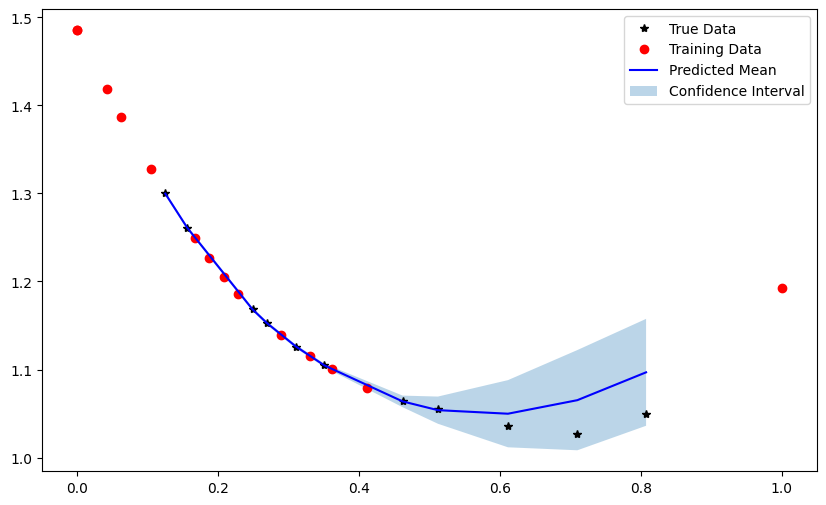

In [18]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

# Flatten for GP training
train_X = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
train_y = torch.tensor(y_train, dtype=torch.float32)
noise_matrix = torch.tensor(noise_matrix, dtype=torch.float32)

# Define a simple GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_X, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_X, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize model and likelihood
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise_matrix.diag())
model = ExactGPModel(train_X, train_y, likelihood)

# Training
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(50):
    optimizer.zero_grad()
    output = model(train_X)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Evaluation Mode
model.eval()
likelihood.eval()

# Predictions
test_X = torch.tensor(X_true, dtype=torch.float32).unsqueeze(-1)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_X))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(X_total, y_true, 'k*', label='True Data')
plt.plot(X_train, y_train, 'ro', label='Training Data')
plt.plot(X_true, observed_pred.mean.numpy(), 'b-', label='Predicted Mean')
plt.fill_between(X_true,
                 observed_pred.mean.numpy() - 2 * observed_pred.variance.sqrt().numpy(),
                 observed_pred.mean.numpy() + 2 * observed_pred.variance.sqrt().numpy(),
                 alpha=0.3, label='Confidence Interval')
plt.legend()
plt.show()

2D Implementation

In [ ]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt


# Flatten for GP training
train_X = torch.tensor(np.column_stack((m, T)), dtype=torch.float32)
train_y = torch.tensor(data.ravel(), dtype=torch.float32)

### --- Method 1: Gaussian Process with GPyTorch --- ###

# Define a simple GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_m, train_T, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_m, train_T, train_y, likelihood)
        
        self.mean_module = gpytorch.means.LinearMean()
        self.covar_module = gpytorch.kernels.scale_kernel( gpytorch.kernels.MaternKernel(nu=2.5))

    def forward(self, m, T):
        mean_x = self.mean_module(m, T)
        covar_x = self.covar_module(m, T)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_X, train_y, likelihood)

# Training
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(50):
    optimizer.zero_grad()
    output = model(train_X)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Evaluation Mode
model.eval()
likelihood.eval()

def compute_gp_gradient_field(model, m_values, T_values):
    M, T = np.meshgrid(m_values, T_values)
    grad_m = np.zeros_like(M)
    grad_T = np.zeros_like(T)

    for i in range(len(m_values)):
        for j in range(len(T_values)):
            x = torch.tensor([[M[j, i], T[j, i]]], dtype=torch.float32, requires_grad=True)
            output = model(x)
            grad_outputs = torch.ones_like(output.mean)
            gradient = torch.autograd.grad(output.mean, x, grad_outputs=grad_outputs, create_graph=True)[0]
            grad_m[j, i], grad_T[j, i] = gradient.detach().numpy().flatten()

    return grad_m, grad_T

# Compute the GP gradient field
grad_m_gp, grad_T_gp = compute_gp_gradient_field(model, m_values, T_values)

### --- Method 2: Finite Differences --- ###

def finite_difference_gradient(m_values, T_values, data):
    grad_m = np.zeros_like(data)
    grad_T = np.zeros_like(data)
    
    # Calculate gradients using central differences
    for i in range(1, len(m_values) - 1):
        for j in range(1, len(T_values) - 1):
            dm = m_values[i+1] - m_values[i-1]
            dT = T_values[j+1] - T_values[j-1]
            
            grad_m[j, i] = (data[j, i+1] - data[j, i-1]) / dm
            grad_T[j, i] = (data[j+1, i] - data[j-1, i]) / dT
            
    return grad_m, grad_T

# Compute the finite difference gradients
grad_m_fd, grad_T_fd = finite_difference_gradient(m_values, T_values, data)

### --- Visualization Function --- ###
def plot_gradient_field(m_values, T_values, grad_m, grad_T, title="Gradient Field"):
    M, T = np.meshgrid(m_values, T_values)
    magnitude = np.sqrt(grad_m**2 + grad_T**2)
    
    # Normalize for visualization
    norm_grad_m = grad_m / (magnitude + 1e-8)
    norm_grad_T = grad_T / (magnitude + 1e-8)
    
    plt.figure(figsize=(10, 8))
    plt.quiver(M, T, norm_grad_m, norm_grad_T, magnitude, cmap='viridis')
    plt.colorbar(label='Gradient Magnitude')
    plt.xlabel('m')
    plt.ylabel('T')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Visualize the GP Gradient Field
plot_gradient_field(m_values, T_values, grad_m_gp, grad_T_gp, title="GP Gradient Field")

# Visualize the Finite Difference Gradient Field
plot_gradient_field(m_values, T_values, grad_m_fd, grad_T_fd, title="Finite Difference Gradient Field")


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

quoteDateData = pd.read_csv('quoteDateData.csv', index_col= False)
quoteDateData.sort_values(by=['m', 'T'], inplace=True)

#quoteDateData[['adj_mid_TIV','adj_ask_TIV','adj_bid_TIV']] *= 100

maturities = quoteDateData['expiration'].unique()
strikes = quoteDateData['strike'].unique()

maturityData = quoteDateData[quoteDateData['expiration'] == maturities[20]]

maturityData[['adj_mid_TIV']]


normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
to_32bit = lambda x: np.array(x, dtype=np.float32)

m = to_32bit(normalize(quoteDateData['m'].values))
T = to_32bit(normalize(quoteDateData['T'].values))

IV = to_32bit((quoteDateData['adj_mid_IV'].values))
TIV = to_32bit((quoteDateData['adj_mid_TIV'].values))

c = 0.25
Z_value = stats.norm.ppf(1 - c / 2)
noise = ((quoteDateData['adj_ask_IV']) - (quoteDateData['adj_bid_IV'])).values**2 / (Z_value**2)
noise = to_32bit((noise))

In [92]:
m = to_32bit(normalize(quoteDateData['m'].values))
T = to_32bit(normalize(quoteDateData['T'].values))

IV = to_32bit((quoteDateData['adj_mid_IV'].values))
TIV = to_32bit((quoteDateData['adj_mid_TIV'].values))

c = 0.25
Z_value = stats.norm.ppf(1 - c / 2)
noise = ((quoteDateData['adj_ask_IV']) - (quoteDateData['adj_bid_IV'])).values**2 / (Z_value**2)
noise = to_32bit((noise))

In [93]:
import plotly.graph_objects as go

# Extract m, T, and y values from train_X and train_y
m_values = m
T_values = T
y_values = IV

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=m_values,
    y=T_values,
    z=y_values,
    mode='markers',
    marker=dict(
        size=5,
        color=y_values,  # Set color to train_y values
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)])

# Set plot layout with smaller figure size
fig.update_layout(
    scene=dict(
        xaxis_title='m',
        yaxis_title='T',
        zaxis_title='train_y'
    ),
    title='3D Scatter Plot of train_X vs train_y',
    margin=dict(l=0, r=0, b=0, t=40),
    width=800,  # Set the width of the figure
    height=500  # Set the height of the figure
)

# Show the plot
fig.show()

In [95]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np



class GPY_Torch_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPY_Torch_Model, self).__init__(train_x, train_y, likelihood)
        #self.mean_module = gpytorch.means.LinearMean(input_size=2)
        self.mean_module = gpytorch.means.ConstantMean()
        self.base_kernel = gpytorch.kernels.MaternKernel(ard_num_dims=2, nu=2.5)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class Base_GP_Model:
    def __init__(self, m_train, T_train, y_train, noise, **kwargs):
        # Get the keyword arguments
        for key, value in kwargs.items():
            setattr(self, key, value)

        # If lr is not provided, set it to 0.1
        if 'lr' not in kwargs:
            self.lr = 0.1
        if 'training_iterations' not in kwargs:
            self.training_iterations = 200

        # Convert to tensors with consistent dtype (torch.float)
        self.train_x = torch.tensor(np.column_stack((m_train, T_train)), dtype=torch.float)
        self.train_y = torch.tensor(y_train, dtype=torch.float)
        self.noise = torch.tensor(noise, dtype=torch.float)
        self.likelihood = None
        self.model = None

    def learn(self, **kwargs):
        if 'noise' in kwargs:
            self.noise = torch.tensor(kwargs['noise'], dtype=torch.float)
        if 'lr' in kwargs:
            self.lr = kwargs['lr']
        if 'training_iterations' in kwargs:
            self.training_iterations = kwargs['training_iterations']

        with gpytorch.settings.min_fixed_noise(float_value = 1e-8):

            # Initialize likelihood
            if self.likelihood is None:
                likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=self.noise, learn_additional_noise=True)
                self.likelihood = likelihood
            else:
                # Use the existing likelihood
                likelihood = self.likelihood


            if self.model is None:
                model = GPY_Torch_Model(self.train_x, self.train_y, likelihood)
                self.model = model
            else:
                # Use the existing model
                model = self.model


            # Set the model and likelihood to training mode
            model.train()
            likelihood.train()

            # Use the Adam optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)

            # "Loss" for GPs - the marginal log likelihood
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

            # Training loop
            training_iterations = self.training_iterations
            losses = []

            for i in range(training_iterations):
                optimizer.zero_grad()
                output = model(self.train_x)  # Use self.train_x instead of train_x
                loss = -mll(output, self.train_y)  # Use self.train_y instead of train_y
                losses.append(loss.item())
                loss.backward()
                optimizer.step()
                
                if (i + 1) % 100 == 0:
                    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item():.4f}')
                    print(f'  lengthscale: {model.covar_module.base_kernel.lengthscale}')
                    print(f'  outputscale: {model.covar_module.outputscale.item():.4f}')


            self.model = model
            self.loss = losses

            # Plot training curve
            plt.figure(figsize=(10, 4))
            plt.plot(losses)
            plt.title("Negative Log Likelihood During Training")
            plt.xlabel("Iterations")
            plt.ylabel("NLL")
            plt.show()

            # Print final parameters
            print(f'Final lengthscale: {model.covar_module.base_kernel.lengthscale}')
            print(f'Final outputscale: {model.covar_module.outputscale.item():.4f}')


    def predict(self, m_test, T_test):
        # Convert test data to tensor
        test_x = torch.tensor(np.column_stack((m_test, T_test)), dtype=torch.float)

        # Set the model and likelihood to evaluation mode
        self.model.eval()
        self.likelihood.eval()

        # Make predictions
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = self.likelihood(self.model(test_x))

        return observed_pred.mean.numpy(), observed_pred.variance.numpy()

C:\Users\Emre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gpytorch\likelihoods\noise_models.py:148: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-08.



Iter 100/500 - Loss: -1.6074
  lengthscale: tensor([[0.9901, 0.3158]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.3484
Iter 200/500 - Loss: -3.2380
  lengthscale: tensor([[0.5881, 0.0327]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.0298
Iter 300/500 - Loss: -3.4234
  lengthscale: tensor([[0.6647, 0.0354]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.0332
Iter 400/500 - Loss: -3.4493
  lengthscale: tensor([[0.7071, 0.0439]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.0472
Iter 500/500 - Loss: -3.4605
  lengthscale: tensor([[0.8369, 0.0434]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.0631


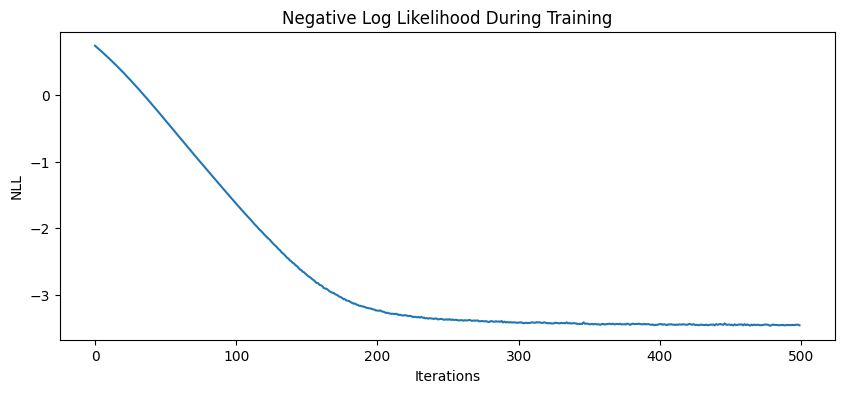

Final lengthscale: tensor([[0.8369, 0.0434]], grad_fn=<SoftplusBackward0>)
Final outputscale: 0.0631


In [378]:
partialQuoteDateData = quoteDateData.sample(frac=0.6, replace=False)

m_train = to_32bit(normalize(partialQuoteDateData['m'].values))
T_train = to_32bit(normalize(partialQuoteDateData['T'].values))

IV_train = to_32bit((partialQuoteDateData['adj_mid_IV'].values))
TIV_train = to_32bit((partialQuoteDateData['adj_mid_TIV'].values))

c = 0.05
Z_value = stats.norm.ppf(1 - c / 2)
noise_train = ((partialQuoteDateData['adj_ask_IV']) - (partialQuoteDateData['adj_bid_IV'])).values**2 / (Z_value**2)
noise_train = to_32bit((noise))


gp_model = Base_GP_Model(m_train, T_train, IV_train, noise_train, lr=0.05, training_iterations=500)
gp_model.learn()

In [388]:
mod  = gp_model.model
lik = gp_model.likelihood

In [389]:
epsilon_m = 0.00001/2
epsilon_tau = 0.00001/2


mod.eval()
lik.eval()

def epsilon_step_m(x, epsilon = 0.00001):
    arr = []
    for i in range(len(x)):
        if i % 2 == 0:       
            arr.append(x[i] - epsilon)
            arr.append(x[i] + epsilon)
            arr.append(x[i])
            arr.append(x[i])
        else:
            arr.append(x[i])
            arr.append(x[i])
            arr.append(x[i] - epsilon)
            arr.append(x[i] + epsilon)
    return np.array(arr, dtype=np.float32)

def epsilon_step_tau(x, epsilon = 0.00001):
    arr = []
    for i in range(len(x)):
        if i % 2 == 0:       
            arr.append(x[i])
            arr.append(x[i])
            arr.append(x[i] - epsilon)
            arr.append(x[i] + epsilon)
        else:
            arr.append(x[i] - epsilon)
            arr.append(x[i] + epsilon)
            arr.append(x[i])
            arr.append(x[i])
    return np.array(arr, dtype=np.float32)


# Create a grid of points to predict
m_test = np.linspace(m.min(), np.percentile(m,95), 30)
T_test = np.linspace(T.min(), np.percentile(T,95), 30)
m_test, T_test = np.meshgrid(m_test, T_test)

m_test = epsilon_step_m( m_test.flatten(), epsilon= epsilon_m)
T_test = epsilon_step_tau( T_test.flatten(), epsilon= epsilon_tau)
m_test = to_32bit( normalize(m_test) )
T_test = to_32bit( normalize(T_test) )

test_X = torch.tensor(np.column_stack((m_test, T_test)), dtype=torch.float32)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions

    f_preds = mod(test_X)
    #y_preds = lik(f_preds)

In [390]:
samples = f_preds.sample(sample_shape=torch.Size([100000]))
s = samples.numpy()
f_minus_m = s[:,1::4]
f_plus_m = s[:,::4]

f_prime_m = (f_plus_m - f_minus_m) / (2 * epsilon_m)
f_avg_prime_m = np.mean(f_prime_m, axis=0)


f_minus_tau = s[:,2::4]
f_plus_tau = s[:,3::4]

f_prime_tau = (f_plus_tau - f_minus_tau) / (2 * epsilon_tau)
f_avg_prime_tau = np.mean(f_prime_tau, axis=0)



In [391]:
theta_sample = np.arctan(f_prime_tau / (f_prime_m + 1e-8))
theta_bar = np.mean(theta_sample, axis=0)
theta_lb = np.quantile(theta_sample, 0.05, axis=0)
theta_ub = np.quantile(theta_sample, 0.95, axis=0)


radius_sample = np.sqrt(f_prime_m**2 + f_prime_tau**2)
radius_bar = np.mean(radius_sample, axis=0)
radius_lb = np.quantile(radius_sample, 0.05, axis=0)
radius_ub = np.quantile(radius_sample, 0.95, axis=0)

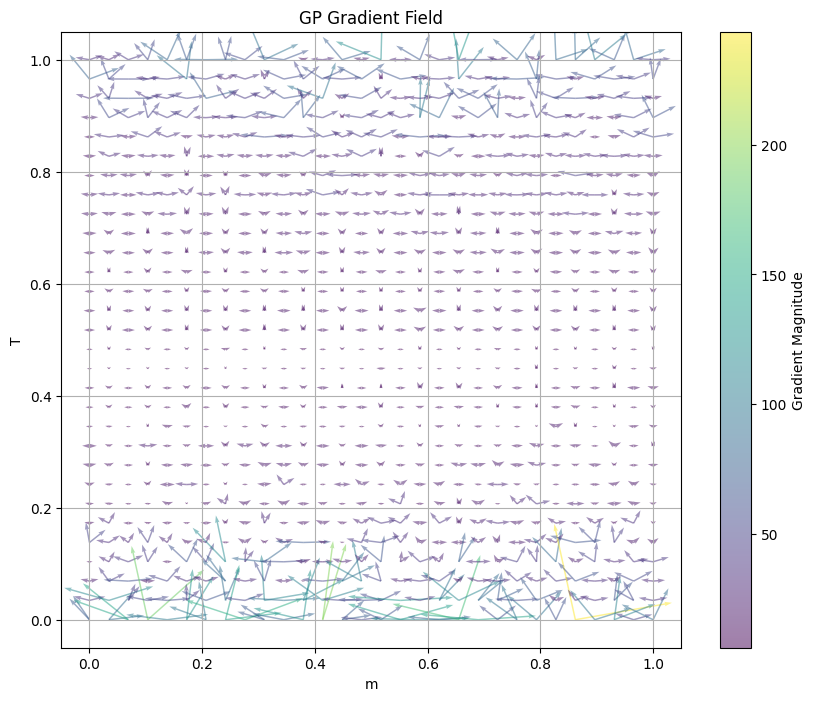

In [395]:
# Create a grid of points to predict
m_test = np.linspace(m.min(), m.max(), 30)
T_test = np.linspace(T.min(), T.max(), 30)
m_test, T_test = np.meshgrid(m_test, T_test)

m_test = m_test.flatten()
T_test = T_test.flatten()
m_test = to_32bit( (m_test) )
T_test = to_32bit( (T_test) )


def plot_gradient_field(m_values, T_values, grad_m, grad_T, train_m, train_T, theta_lb, title="Gradient Field"):
    magnitude = np.sqrt(grad_m**2 + grad_T**2)
    norm_grad_m = grad_m / (magnitude + 1e-8)
    norm_grad_T = grad_T / (magnitude + 1e-8)
    
    plt.figure(figsize=(10, 8))
    #plt.scatter(train_m, train_T, c='gray', s=3, label='Training Points', alpha = 0.2)
    #plt.quiver(m_values, T_values, grad_T * np.sin(grad_m), grad_T * np.cos(grad_m), magnitude, cmap='plasma')
    plt.quiver(m_values, T_values, grad_T * np.sin(grad_m), grad_T * np.cos(grad_m), magnitude, color='black', alpha=0.5, label='Gradient Direction')
    plt.quiver(m_values, T_values, grad_T * np.sin(theta_lb), grad_T * np.cos(theta_lb), magnitude, color='black', alpha=0.5, label='Gradient Direction')

    plt.colorbar(label='Gradient Magnitude')
    plt.xlabel('m')
    plt.ylabel('T')
    plt.title(title)
    plt.grid(True)
    plt.show()



plot_gradient_field(m_test, T_test, theta_ub, radius_bar, normalize(m_train), normalize(T_train), theta_lb, title="GP Gradient Field")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


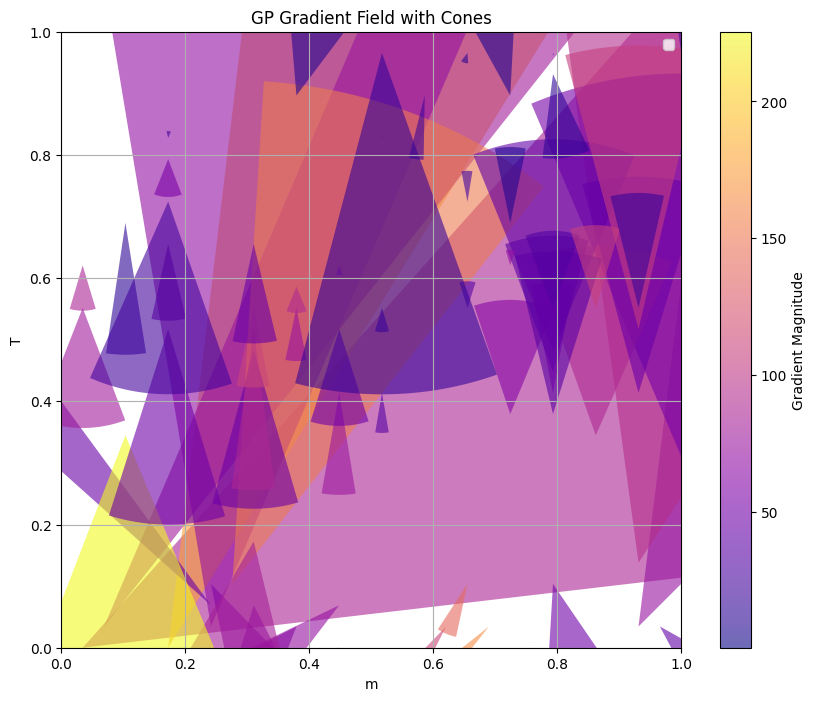

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def plot_cones_with_arcs(m_values, T_values, train_m, train_T, grad_m, grad_T, radius_bar, theta_lb, theta_ub, max_angle=np.pi/4, title="Gradient Field with Cones"):
    plt.figure(figsize=(10, 8))
    patches = []

    for i in range(len(m_values)):
        # Base point
        x0, y0 = m_values[i], T_values[i]

        # Compute the angle between the two vectors
        angle_diff = abs(theta_ub[i] - theta_lb[i])
        if angle_diff > max_angle:
            continue  # Skip if the angle is too wide

        # Generate points for the circular arc
        arc_angles = np.linspace(theta_lb[i], theta_ub[i], 50)
        arc_x = x0 + grad_m[i] * np.sin(arc_angles)
        arc_y = y0 + grad_T[i] * np.cos(arc_angles)

        # Create a polygon that includes the base point and the arc
        polygon_points = np.vstack([[x0, y0], np.column_stack((arc_x, arc_y))])
        triangle = Polygon(polygon_points, closed=True)
        patches.append(triangle)

    # Add all polygons to the plot
    p = PatchCollection(patches, cmap='plasma', alpha=0.6)
    p.set_array(np.array([np.sqrt(grad_m[i]**2 + grad_T[i]**2) for i in range(len(m_values))]))  # Color based on gradient magnitude
    plt.gca().add_collection(p)

    # Add colorbar
    plt.colorbar(p, label='Gradient Magnitude')

    # Plot training points (optional)
    #plt.scatter(train_m, train_T, c='gray', s=3, label='Training Points', alpha=0.2)


    plt.xlabel('m')
    plt.ylabel('T')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


# Example usage
plot_cones_with_arcs(m_test, T_test, f_avg_prime_m, f_avg_prime_tau, normalize(m_train), normalize(T_train), theta_lb, theta_ub, title="GP Gradient Field with Cones")

In [183]:
theta_bar

array([-1.33214384e-01, -9.42592144e-01, -7.02675700e-01,  7.36530125e-01,
       -6.79140031e-01,  1.17398456e-01,  1.16040587e+00,  8.35310280e-01,
        9.62691128e-01, -3.35787237e-01,  6.55979395e-01, -3.03359568e-01,
       -1.38851240e-01,  7.48705983e-01,  1.24547493e+00,  6.69144988e-01,
       -4.38408285e-01, -6.87183559e-01, -1.21251118e+00,  2.77872115e-01,
       -5.05798280e-01,  6.72777057e-01, -1.18333206e-01, -1.06196332e+00,
        1.04015231e+00, -6.80109739e-01, -1.45674324e+00,  4.95651901e-01,
       -9.04524446e-01, -7.68031240e-01, -8.90429020e-01, -7.99130574e-02,
       -8.09692383e-01,  1.12413359e+00, -3.32954705e-01,  1.50486723e-01,
        5.07916093e-01, -3.33475828e-01, -9.20431137e-01,  5.67148805e-01,
        4.50980216e-02,  8.24905753e-01,  1.29890561e+00,  9.07057762e-01,
       -9.50806618e-01, -1.45620763e-01, -2.28178307e-01,  7.85477519e-01,
       -7.37231523e-02, -4.33274567e-01,  7.89436698e-01,  1.01487482e+00,
        1.09580122e-01,  

In [387]:
import plotly.graph_objects as go

# Extract m, T, and y values from train_X and train_y
m_values = m_test
T_values = T_test
y_values = y_preds.loc.numpy()

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=m_values,
    y=T_values,
    z=y_values,
    mode='markers',
    marker=dict(
        size=5,
        color=y_values,  # Set color to train_y values
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)])

# Set plot layout with smaller figure size
fig.update_layout(
    scene=dict(
        xaxis_title='m',
        yaxis_title='T',
        zaxis_title='train_y'
    ),
    title='3D Scatter Plot of train_X vs train_y',
    margin=dict(l=0, r=0, b=0, t=40),
    width=800,  # Set the width of the figure
    height=500  # Set the height of the figure
)

# Show the plot
fig.show()

In [ ]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for the S&P 500 index
spx_ticker = "^SPX"

# Create a Ticker object
spx = yf.Ticker(spx_ticker)

# Fetch the available expiration dates for SPX options
exp_dates = spx.options

# Initialize an empty DataFrame to store all options data
all_options = pd.DataFrame()

# Iterate over each expiration date to fetch options data
for exp_date in exp_dates:
    # Fetch the options chain for the given expiration date
    opt_chain = spx.option_chain(exp_date)

    # Combine call and put options data
    options_data = pd.concat([opt_chain.calls, opt_chain.puts])

    # Add a column for the expiration date
    options_data['expirationDate'] = exp_date

    # Append to the main DataFrame
    all_options = pd.concat([all_options, options_data], ignore_index=True)

S_0 = current_spx_price = spx.info['regularMarketPrice']

In [ ]:
import yfinance as yf

# Ticker symbols for common SPX-related futures provided by Yahoo Finance
spx_futures_tickers = ['ES=F', 'MES=F']  # ES: E-mini, MES: Micro E-mini

# Retrieve futures data
futures_data = {}

for ticker in spx_futures_tickers:
    future = yf.Ticker(ticker)
    info = future.info
    
    futures_data[ticker] = {
        'symbol': ticker,
        'currentPrice': info.get('regularMarketPrice'),
        'bid': info.get('bid'),
        'ask': info.get('ask'),
        'bidSize': info.get('bidSize'),
        'askSize': info.get('askSize'),
        'volume': info.get('volume'),
        'openInterest': info.get('openInterest'),
        'previousClose': info.get('previousClose'),
        'marketTime': info.get('regularMarketTime')
    }

# Display data
import pandas as pd
df = pd.DataFrame.from_dict(futures_data, orient='index')
print(df)


In [1]:
S_0 = 5633.07

spxw_symbols = all_options[all_options['contractSymbol'].str.startswith('SPXW')]
spx_symbols = all_options[all_options['contractSymbol'].str.startswith('SPX')]

maturities = spx_symbols['expirationDate'].unique()

spx_symbols['contractSymbol'] = spx_symbols['contractSymbol'].str.replace('^SPX', '', regex=True)

q_set = []
mat_set = []
div_paym = []

for maturity in maturities:
    maturityData = spx_symbols[spx_symbols['expirationDate'] == maturity]
    maturityData = maturityData.sort_values(by=['contractSymbol'])

    quote_date = dt(2025, 4, 1, 15, 0)  # Example quote date
    T = calculate_time_to_maturity(quote_date, dt.strptime(maturity, '%Y-%m-%d'))
    r = div_yield(T)

    callData = maturityData[maturityData['contractSymbol'].str.contains('C')]
    putData = maturityData[maturityData['contractSymbol'].str.contains('P')]

    commonStrikes = set(callData['strike']).intersection(set(putData['strike']))
    commonStrikes = np.array(list(commonStrikes))

    q_values = []
    weights_relative_spread = []
    weights_normal = []

    for strike in commonStrikes:
        call_bid = callData[callData['strike'] == strike]['bid'].values[0]
        call_ask = callData[callData['strike'] == strike]['ask'].values[0]
        put_ask = putData[putData['strike'] == strike]['ask'].values[0]
        put_bid = putData[putData['strike'] == strike]['bid'].values[0]

        if call_bid == 0 or put_ask == 0 or call_ask ==0  or put_ask ==0:
            continue

        if call_ask - call_bid > 1 or put_ask - put_bid > 1:
            continue

        F = strike + np.exp(r * T) * (call_bid - put_ask)
        effective_rate = np.log(F / S_0) / T
        q = r - effective_rate
        q_values.append(q)

        # Weight by relative bid-ask spread
        call_spread = call_ask - call_bid
        put_spread = put_ask - put_bid
        relative_spread = 1 / (call_spread + put_spread)  # Inverse of spread
        weights_relative_spread.append(relative_spread)

        # Weight by standard normal distribution centered at ATM
        atm_weight = np.exp(-0.5 * ((strike - S_0) / (0.1 * S_0))**2)  # Standard normal
        weights_normal.append(atm_weight)

    q_values = np.array(q_values)

    if len(q_values) == 0:
        continue

    # Normalize weights
    weights_relative_spread = np.array(weights_relative_spread)
    weights_relative_spread /= weights_relative_spread.sum()

    weights_normal = np.array(weights_normal)
    weights_normal /= weights_normal.sum()

    # Weighted averages
    q_weighted_relative_spread = np.sum(q_values * weights_relative_spread)
    q_weighted_normal = np.sum(q_values * weights_normal)

    # Choose one method (e.g., relative spread) for final q
    q_final = q_weighted_relative_spread  # Or use q_weighted_normal

    q_set.append(q_final)
    mat_set.append(T)
    div_paym.append(((np.exp(q_final * T) - 1) * S_0))

NameError: name 'all_options' is not defined